In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP, SingleTaskGP
from botorch.models.gp_regression_mixed import MixedSingleTaskGP #should be using this due to discrete variable
from botorch.posteriors.gpytorch import scalarize_posterior
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy
from botorch.acquisition import PosteriorMean 
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from botorch import test_functions
import numpy as np
from scipy.spatial.distance import cdist
from botorch import fit_gpytorch_mll
torch.set_printoptions(precision=12, sci_mode=False)
import copy
import math
import matplotlib.pyplot as plt
import random
import time
import pickle
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import summit
from summit.benchmarks import get_pretrained_reizman_suzuki_emulator
from summit.utils.dataset import DataSet
from summit import *
import pkg_resources, pathlib


Defining emulator and bounds for parameter space (numerical parameters only)

In [69]:
emulator = get_pretrained_reizman_suzuki_emulator(case=1)

parameter_space = {
        "catalyst_loading": (0.5, 2.0),
        "temperature": (30, 110), 
        "t_res": (60, 600),
    }
bounds = torch.tensor(
    [[v[0] for v in parameter_space.values()],  # Lower bounds
     [v[1] for v in parameter_space.values()]],  # Upper bounds
    dtype=torch.float32
)

print(bounds)

tensor([[    0.500000000000,    30.000000000000,    60.000000000000],
        [    2.000000000000,   110.000000000000,   600.000000000000]])


In [70]:

#adapted evaluate candidates function that interprets tensors required for BOTorch and converts to df expected by summit
def evaluate_candidates(candidates: pd.DataFrame) -> pd.DataFrame:

    name_map = {
        "Catalyst Loading": "catalyst_loading",
        "Residence Time": "t_res",
        "Temperature": "temperature",
        "Yield": "yld",
        "TON": "ton",
    }
    candidates = candidates.rename(columns=name_map)
    candidates = candidates.astype(np.float64) 

    if 'catalyst' not in candidates.columns:
        candidates.insert(0, 'catalyst', 'P1-L1') #hard coding catalayst P1-L1

    conditions = summit.DataSet.from_df(candidates)

    emulator_output = emulator.run_experiments(
        conditions, rtn_std=True
    ).rename(columns=dict(zip(name_map.values(), name_map.keys())))
    
    return emulator_output["Yield"]


def tensor_to_dataframe(tensor_data, column_names):
    """Convert a tensor to a Pandas DataFrame with given column names."""
    return pd.DataFrame(tensor_data.numpy(), columns=column_names)

def evaluate_tensor(train_x_full, column_names):
    """Evaluates each row in a tensor using the evaluate_candidates function."""
    df_candidates = tensor_to_dataframe(train_x_full, column_names)
    

    results = []
    for _, row in df_candidates.iterrows():
        result = evaluate_candidates(pd.DataFrame([row]))  # convert single row to DataFrame
        results.append(result.values[0])  # extract the yield value
    

    return torch.tensor(results).unsqueeze(-1)  




def sample_parameters(spaceSize, parameter_space):
    """
    Generates samples from the defined parameter space.
    """
    sampled_points = []
    
    for _ in range(spaceSize):
        sample = []
        for param, values in parameter_space.items():
            if isinstance(values, tuple): 
                sample.append(random.uniform(*values))
            elif isinstance(values, list): 
                sample.append(random.choice(values))
        sampled_points.append(sample)
    
    return np.array(sampled_points)

def setUpSampleSpace(spaceSize=200, var=1, lf_cost=0.1): #function creates a sample space of random points (both hf and lf) within bounds

    parameter_space = {
        "catalyst_loading": (0.5, 2.0),
        "temperature": (30, 110), 
        "t_res": (60, 600),
    }

    lf_cost = torch.tensor([lf_cost])
    Xpr_before = sample_parameters(spaceSize, parameter_space)
    Xpr = [i.astype(np.float64) for i in Xpr_before]

    Xpr_tensor = torch.tensor(Xpr, dtype=torch.float32)

    column_names = [ "Catalyst Loading", "Temperature", "Residence Time"]
    output =evaluate_tensor(Xpr_tensor, column_names=column_names)

    X_total_hf = torch.cat((Xpr_tensor, output), dim=1)

    ones_column = torch.ones((X_total_hf.shape[0], 1), dtype=torch.float32)

    X_total_hf = torch.cat((X_total_hf[:, :-1], ones_column, X_total_hf[:, -1:]), dim=1) #add 1.0 fidelity to hf tensors

    domain = []
    for index, hf in enumerate(X_total_hf):
        domain.append(hf)

        lf_y = hf[-1] + torch.tensor(random.gauss(0, var))  #adding gaussian noise
        lf_y = torch.tensor(max(0, lf_y.item())).reshape(1) #prevent negative target values i..e cap at zero

        value = torch.cat(( lf_cost, lf_y), dim=0)
        updated_lf = torch.cat((Xpr_tensor[index][0:3], value), dim=0)
        domain.append(updated_lf)

    #print(domain)
    unique_domain = set(tuple(row.tolist()) for row in domain)
    print(f"Unique samples: {len(unique_domain)}, Total samples: {len(domain)}")    
    domain = torch.stack(domain)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fileName = 'SampleSpaces/' + timestr + '.csv'
    os.makedirs('SampleSpaces/', exist_ok=True)
    np.savetxt(fileName, domain, delimiter=',')

    return fileName

#creates an initial sample from the overall sample space
def setUpInitialData(sampleSpaceName, initialSize=10, predefined_indices = None, sf=False, file=True):
      # The file argument is telling us whether we expect the sampleSpaceName to be a file or the actual domain is already in memory.
      # The predefined_indices argument us used in the batch case across multiple search-algorithms where we want 
      #  each element in the batch to have the same intitial set up so that we can compare the averages fairly.
      sampleSpace = np.loadtxt(sampleSpaceName, delimiter=',') if file else sampleSpaceName
      if predefined_indices is None:
            bad_range = True
            top_size = len(sampleSpace) //20
            hf_points = sampleSpace[np.where(sampleSpace[:, -2]==1)]
            top_5_percent = hf_points[hf_points[:, -1].argsort()[::-1]][0:top_size, 0]

            while bad_range:
                  bad_range = False
                  sampleSpace_hf = sampleSpace[np.where(sampleSpace[:, -2]==1)]
                  size = len(sampleSpace_hf)
                  index_store = random.sample(range(size), initialSize)
                  #This gets the high fidelity and low fidelity points in pairs if we're doing MF.
                  sampleSpace, index_store = (sampleSpace_hf, index_store) if sf else (sampleSpace, [2 * x  for x in  index_store] + [1 + 2 * x for x in index_store])
                  fidelity_history = sampleSpace[index_store, -2]
                  #print(fidelity_history)
                  train_X = sampleSpace[index_store, :-1]
                  train_obj = sampleSpace[index_store, -1:]

                  #Do not have an intitial sample that includes the top 5% of points                  
                  for row in train_X:
                       if row[0] in top_5_percent:
                            bad_range=True
                            break
                  
            return torch.tensor(train_X), torch.tensor(train_obj), sampleSpace, index_store, fidelity_history.flatten().tolist()
      else:
            fidelity_history = sampleSpace[predefined_indices, -2]
            train_X = sampleSpace[predefined_indices, :-1]
            train_obj = sampleSpace[predefined_indices, -1:]
            return torch.tensor(train_X), torch.tensor(train_obj), sampleSpace, predefined_indices, fidelity_history.flatten().tolist()
      



In [71]:

#general helper functions:

def generate_batch_indices(sampleSpaceName, initialSize=5, batch_size=5):
      batch_index_store = []
      for batch_no in range(batch_size):
          _, _, _, index_store,_ = setUpInitialData(sampleSpaceName, initialSize, file=False)
          batch_index_store.append(index_store)
      return batch_index_store
     
def create_dictionary_from_batch(batch_dictionary):
    keys = batch_dictionary.keys()
    expanded_dict={}
    for key in keys:
        trainx_batch, objx_batch, cumx_batch = batch_dictionary[key]
        for i in range(len(trainx_batch)):
            expanded_dict[key+str(i)] = (trainx_batch[i], objx_batch[i], cumx_batch[i])
    return expanded_dict
     
# Required when we want to ensure that the sf has the same hf points in its intitial sampel as the mf case.
def convertMFDatatoSFData(sampleSpace, indexStore):
      sampleSpace_hf = sampleSpace[np.where(sampleSpace[:, -2]==1)]
      index_store = [x // 2 for x in indexStore if x % 2 == 0]
      
      return torch.tensor(sampleSpace_hf[index_store, : -1]), torch.tensor(sampleSpace_hf[index_store, -1:]), sampleSpace_hf, index_store, sampleSpace_hf[index_store, -2].flatten().tolist()#sampleSpace[index_store, 1].flatten().tolist()
    

def save_dictionary(dictionary, batch=False, root='SearchDictionaries'):
      os.makedirs(root, exist_ok=True)
      timestr = time.strftime("%Y%m%d-%H%M%S")
      fileName = root + '/' + 'Batch_' + timestr if batch else root + '/' + timestr
      with open(fileName, 'wb') as handle:
         pickle.dump(dictionary, handle)
      return fileName

def load_dictionary(file):
    with open(file, 'rb') as inp:
      output = pickle.load(inp)
      return output

def save_image(fig, root='Images/'):
      os.makedirs(root, exist_ok=True)
      timestr = time.strftime("%Y%m%d-%H%M%S")
      fig.savefig(f'{root}/{timestr}')
            

def compute_correlation(domain):
      hf_points = np.where(domain[:, -2] == 1)
      lf_points = np.where(domain[:, -2] != 1)
      print(domain[hf_points, -1], domain[lf_points, -1])
      return np.corrcoef(domain[hf_points, -1], domain[lf_points, -1])[0,1]

**acqfs**

In [72]:
def runMes(model, bounds, fidelity_history, previous_evaluations=None, train_x_past=None):
    fidelities = np.unique(fidelity_history)

    min_vals = bounds[0]  
    max_vals = bounds[1]

    candidate_set_no_hf = min_vals + (max_vals - min_vals) * torch.rand(10000, bounds.shape[1])
    candidate_set = torch.tensor(np.concatenate((candidate_set_no_hf, np.array([[random.choice(fidelities) for x in range(10000)]]).T), axis=1))
    #qMultiFidelityMaxValueEntropy requires a candidate set input to discretize sample space

    fidelity_index = candidate_set.shape[1] -1
    target_fidelities = {fidelity_index: 1.0}  #column containing fidelities and target fidelity number
    #print('runMES target_fidelities', target_fidelities)
    
    cost_model = AffineFidelityCostModel(fidelity_weights=target_fidelities, fixed_cost=1.0) #fixed cost potentially needs reviewing - see BOTorch tutorial
    
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    acquisition = qMultiFidelityMaxValueEntropy(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            candidate_set=candidate_set,
            maximize=True
        )
    
    acquisitionScores = acquisition.forward(candidate_set.reshape(-1, 1, bounds.shape[1]+1))

    return acquisitionScores, candidate_set

below EI function has been adapted to sample from a candidate set like MES function - may change 

In [73]:
def runEI(model, bounds, fidelity_history, previous_evaluations, train_x_past=None): 
    
    min_vals = bounds[0]  
    max_vals = bounds[1]

    candidate_set_ei= min_vals + (max_vals - min_vals) * torch.rand(10000, bounds.shape[1])
    ones_column = torch.ones((candidate_set_ei.shape[0], 1), dtype=torch.float32)
    candidate_set = torch.cat((candidate_set_ei, ones_column), dim=1)

    acquisition = ExpectedImprovement(
            model=model,
            best_f= max(previous_evaluations),
            maximize=True
        )
    
    acquisitionScores =  acquisition.forward(candidate_set.reshape(-1,1, bounds.shape[1]+1) ).detach()
    
    return acquisitionScores, candidate_set

optimise acqf -> suggests candidate from acquisiton scores & uses evaluate_candidates function to extract target value (yield)

In [83]:
def optimiseAcquisitionFunction(acq_function, index_store, bounds, candidate_set):
    """suggest a new candidate within the search space using a given acquisition function."""
    

    candidate_idx = torch.argmax(acq_function)
    candidate = candidate_set[candidate_idx]

    candidate_tensor = torch.tensor(candidate[0:-1], dtype=torch.float32).unsqueeze(0)
    fidelity = candidate[-1].item()
    

    candidate_tuple = tuple(candidate.squeeze().tolist())
    if candidate_tuple in index_store:
        print("Candidate already evaluated, selecting a new one.")
        return optimiseAcquisitionFunction(acq_function, index_store, bounds, candidate_set)
    index_store.append(candidate_tuple)  

    
    # Evaluate the new candidate
    column_names = ["Catalyst Loading", "Temperature", "Residence Time"]
    output = evaluate_tensor(candidate_tensor, column_names=column_names)

    if math.isclose(fidelity, 0.1, rel_tol=1e-5): #lf case -> add gaussian noise (same variance as before)
        output = output + random.gauss(0, 10)

    print("candidate_tensor", candidate_tensor, output)

    return candidate, output, fidelity

function to run BO cycle up to budget limit

In [75]:
def run_entire_cycle(train_x_full, 
                     train_obj, 
                     fidelity_history, 
                     index_store, 
                     func,
                     sf=False, 
                     no_of_iterations=100000, 
                     allocated_budget=100000
                     ):
    """Runs the full optimization cycle with continuous search space handling."""
    
    train_x_full = copy.deepcopy(train_x_full)
    train_obj = copy.deepcopy(train_obj)
    fidelity_history = copy.deepcopy(fidelity_history)
    index_store = copy.deepcopy(index_store)

    budget_sum = sum(fidelity_history)
    iteration_counter = 0
    
    while budget_sum <= allocated_budget - 1 and iteration_counter < no_of_iterations:
        model = SingleTaskGP(train_x_full, train_obj) if sf else SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelities=[-1])
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        
        acquisition_function, candidate_set = func(model=model, bounds = bounds, fidelity_history = fidelity_history, previous_evaluations=train_obj, train_x_past=train_x_full)
        
        top_candidate, evaluation, fidelity = optimiseAcquisitionFunction(acquisition_function, index_store, bounds=bounds, candidate_set = candidate_set)

        print('fidelity',fidelity)
        fidelity_history.append(fidelity)

        train_x_full = torch.cat([train_x_full, top_candidate.unsqueeze(0)]) #add conditions to x tensor
        train_obj = torch.cat([train_obj, torch.tensor([evaluation]).unsqueeze(-1)]) #add target output value to x tensor

        iteration_counter += 1
        budget_sum += fidelity
        
    cumulative_cost = np.cumsum(fidelity_history).tolist()
    
    return train_x_full, train_obj, cumulative_cost, index_store

In [76]:

setup_file = setUpSampleSpace(spaceSize=100, var=10, lf_cost=0.1)
print('setup file:',setup_file)

N_INIT = 5
ALLOCATED_BUDGET = 50
fileName = setup_file
print(fileName)
train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(fileName, N_INIT)

print('Correlation (HF vs LF):', compute_correlation(domain=domain))


Unique samples: 200, Total samples: 200
setup file: SampleSpaces/20250313-163035.csv
SampleSpaces/20250313-163035.csv
[[14.85267067 29.14748192 40.02074432 13.03937817 48.03563309  8.75144672
  14.19190407  6.91912985 40.50442123 16.2580986  41.18724442 13.8452549
  30.0345211  19.99373436 23.08507919 35.63340759 16.15735245 27.28399086
   6.26551104 28.67354965 59.49337006 41.33620453 13.08900738 19.25155258
  24.01729393 22.01675797 30.00095177 32.89542389  9.31792164 34.52706528
  40.00278091 21.68532753 26.98862839 10.02043724 39.05811691 34.77193451
  29.93397903 31.9274292  12.75058746  5.55461073 28.20198059 18.33720016
   5.25285387 11.02577782 26.20932579 41.28394699 44.50201416 26.88720131
  41.19709015 45.52548599 42.95142746 14.30678272 34.35773468 53.66233063
  13.51499367 17.58069611 28.1348362  50.14887238 30.63738441 45.79570007
  44.63690948 24.39089203 35.29909134 50.82026672  5.82505798 36.29465485
  42.94155884  4.58489132 11.02520943 15.90296364 29.0705471  58.2569

In [77]:

train_x_full_mes, train_obj_mes, cumulative_cost_mes, index_store_mes = run_entire_cycle(
    train_x_full, 
    train_obj, 
    fidelity_history,
    index_store,
    runMes,
    allocated_budget=ALLOCATED_BUDGET
    )

runMES target_fidelities {3: 1.0}
candidate_tensor tensor([[  1.797577738762,  71.495498657227, 280.151763916016]]) tensor([[32.236232757568]])
fidelity 0.10000000149011612
runMES target_fidelities {3: 1.0}
candidate_tensor tensor([[  1.022658467293,  70.336715698242, 592.749938964844]]) tensor([[30.426250457764]])
fidelity 0.10000000149011612
runMES target_fidelities {3: 1.0}
candidate_tensor tensor([[  1.891404390335,  71.385101318359, 279.188903808594]]) tensor([[53.071182250977]])
fidelity 0.10000000149011612
runMES target_fidelities {3: 1.0}
candidate_tensor tensor([[  0.878120064735,  70.494857788086, 592.632263183594]]) tensor([[26.770183563232]])
fidelity 0.10000000149011612
runMES target_fidelities {3: 1.0}
candidate_tensor tensor([[  0.794946610928,  83.879318237305, 379.601501464844]]) tensor([[11.879238128662]])
fidelity 0.10000000149011612
runMES target_fidelities {3: 1.0}
candidate_tensor tensor([[  0.619120717049, 109.013732910156, 166.580566406250]]) tensor([[24.7932167

In [78]:
train_x_full_sf, train_obj_sf, domain_sf, index_store_sf, fidelity_history_sf = convertMFDatatoSFData(domain, index_store)
print(index_store_sf)
print(fidelity_history_sf)
train_x_full_ei, train_obj_ei, cumulative_cost_ei, index_store_ei= run_entire_cycle(
    train_x_full_sf, 
    train_obj_sf, 
    fidelity_history_sf,
    index_store_sf,
    runEI,
    sf=True,
    allocated_budget=ALLOCATED_BUDGET)

[52, 30, 72, 49, 10]
[1.0, 1.0, 1.0, 1.0, 1.0]
candidate_tensor tensor([[  0.823404073715,  94.884094238281, 590.541076660156]]) tensor([[35.770484924316]])
fidelity 1.0
candidate_tensor tensor([[  0.888065457344,  82.091522216797, 379.981109619141]]) tensor([[29.541280746460]])
fidelity 1.0
candidate_tensor tensor([[  1.794670224190,  82.282966613770, 380.341430664062]]) tensor([[42.390113830566]])
fidelity 1.0
candidate_tensor tensor([[  1.600417256355,  81.985488891602, 382.568634033203]]) tensor([[39.989982604980]])
fidelity 1.0
candidate_tensor tensor([[  1.699854373932, 108.701309204102, 165.926025390625]]) tensor([[63.130950927734]])
fidelity 1.0
candidate_tensor tensor([[  1.387024641037, 108.727653503418, 162.997253417969]]) tensor([[55.496440887451]])
fidelity 1.0
candidate_tensor tensor([[  1.909906148911, 108.755737304688, 174.684646606445]]) tensor([[67.008987426758]])
fidelity 1.0
candidate_tensor tensor([[  1.979775905609, 108.577796936035, 163.404235839844]]) tensor([[6

In [79]:
modelDict = {
    
    "MF-MES": (train_x_full_mes, train_obj_mes, cumulative_cost_mes),
    "SF-EI" : (train_x_full_ei, train_obj_ei, cumulative_cost_ei),
             }
dict_filename = save_dictionary(modelDict, batch=False) 
print(dict_filename)

modelDict = load_dictionary(f'{dict_filename}')
domain = np.loadtxt(f'{fileName}', delimiter=',')

SearchDictionaries/20250313-164122


In [45]:

def plot_fidelities(samples, targets, cumulated_cost, title, total_domain, colours=['red', 'blue', 'green']):
    max_in_space= np.max(total_domain[np.where(total_domain[:, -2] == 1.0)][:, -1])
    print(max_in_space)
    max_reached = targets[np.where(samples[:, -1] == 1.0)].max()
    print(max_reached)
    index_array = np.where(targets == max_reached)[0]

    for index in index_array:
        if samples[index, -1] == 1.0:
            index_of_max = index 

    samples = samples.detach().numpy()
    targets = targets.detach().numpy()
    fidelities = list(dict.fromkeys(np.round(samples[:, -1], 3)))
    fidelities.sort(reverse=True)
    for fidelity in fidelities:
        fidelity_target=[]
        fidelity_iteration=[]
        for i in range(len(cumulated_cost)):
            if (round(samples[i, -1],3) == fidelity):
                fidelity_target.append(targets[i])
                fidelity_iteration.append(cumulated_cost[i])
        # maximum_target.append(max(df_total[df_total['fidelity']==fidelity]['target']))
        legend_text = f'Fidelity: {round(fidelity, 3)}'
        plt.scatter(fidelity_iteration, fidelity_target, label=legend_text, color=colours[fidelities.index(fidelity)], alpha=0.5)
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Domain Optimum')
    plt.axvline(x=cumulated_cost[index_of_max], color='black', linestyle=':')
    plt.axhline(y=max_reached, color='black', linestyle=':', label='Obtained Optimum')
    
    # plt.legend(loc="lower right")
    plt.xlabel("Accumulated Cost")
    plt.ylabel("Evaluation")
    #plt.ylim([min(targets)-1, max_in_space +1])
    plt.title(title)

def plot_fidelities_for_dict(dictionary, dictionary_domain, allocated_budget=50, number_init=5):
    figure = plt.figure(figsize=(13,11))
    no_of_rows = math.ceil(len(dictionary.keys())/2)
    # for id, key in enumerate(dictionary):
    #     plt.subplot(no_of_rows, 2, id + 1)
    #     plot_fidelities(dictionary[key][0], dictionary[key][1], dictionary[key][2], f'{key}', dictionary_domain)
    for id, key in enumerate(list(dictionary.keys())):
        plt.subplot(no_of_rows, 2, id + 1)
        plot_fidelities(dictionary[key][0], dictionary[key][1], dictionary[key][2], f'{key}', dictionary_domain)
    handles, labels = plt.gca().get_legend_handles_labels()
    #for key in list(dictionary.keys())[-1:]:
        #plt.subplot(2, 2, 4)
        #plot_fidelities(dictionary[key][0], dictionary[key][1], dictionary[key][2], f'{key}', dictionary_domain)
    # plt.suptitle(f'{number_init} Initial Samples, {allocated_budget} Budget, Domain-size {int(len(dictionary_domain)/2)}',  size=16)
    plt.subplots_adjust(top=0.93)
    plt.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor = (0, -0.01, 1, 1),
           bbox_transform = plt.gcf().transFigure)
    figure.subplots_adjust(hspace=0.3)
    plt.show(block=False)

plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=16)
plt.rc('axes', titlesize=16)



# Here we plot the maximum high-fidelity target reached so far with a given cost. 
def plot_cost(domain, dictionary, title): 
    #max_in_space= np.max(domain[np.where(domain[:, -2] == 1.0)])
    max_in_space = np.max(domain[np.where(domain[:, -2] == 1.0), -1])

    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        cumulative_cost_array = np.array(cumulative_cost)
        hf_indices = np.where(train_x_full[:, -1]==1.0)
        high_fidelity_obj = train_obj[np.where(train_x_full[:, -1]==1.0)].detach().numpy()
        accum_target = []
        for i in range(len(high_fidelity_obj)):
            accum_target.append(max(high_fidelity_obj[0:i+1]))

        plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=search_alg)    
        plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
        plt.xlabel('Accumulated Cost')
        plt.ylabel('Max High-Fidelity Evaluation')
        plt.title(title)
        plt.legend()
        plt.show(block=False)


def plot_histogram(domain):
    high_fidelity = domain[np.where(domain[:, -2]==1.0)]
    low_fidelity = domain[np.where(domain[:, -2]!= 1.0)]
    correlation = np.corrcoef(high_fidelity[:, -1], low_fidelity[:, -1])[0,1]

    plt.hist(low_fidelity[:, -1], label=f'Low-fidelity Data (Correlation: {str(correlation)[:3]})', bins=20, alpha=0.5, color='blue')
    plt.hist(high_fidelity[:, -1], label='High-fidelity Data', bins=20, alpha=0.5, color='red')
    # plt.title('Distribution of Evaluations')
    plt.xlabel('f(x)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show(block=False)


59.493370056152344
tensor(65.027297973633, dtype=torch.float64)
59.493370056152344
tensor(69.797187805176, dtype=torch.float64)


<Figure size 640x480 with 0 Axes>

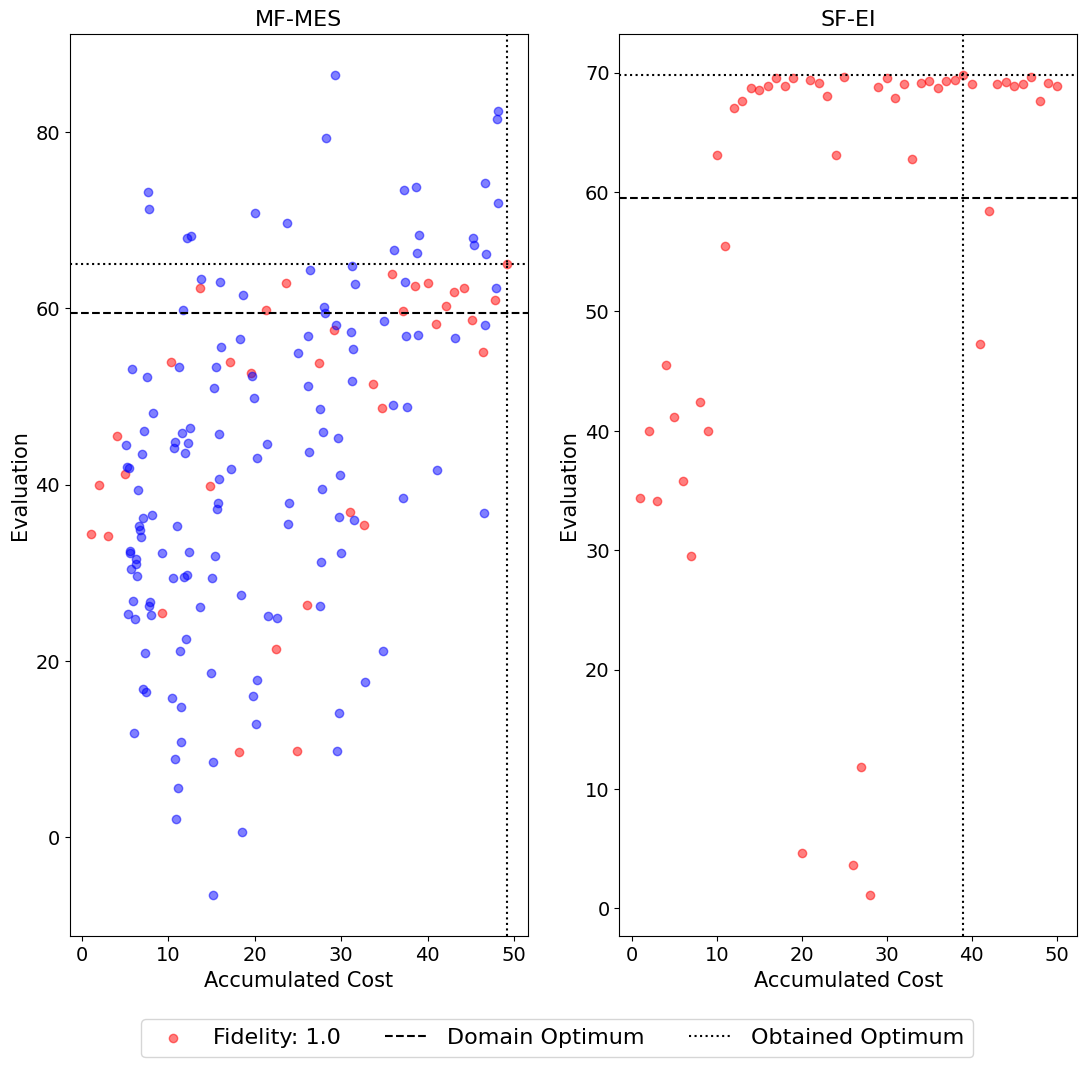

In [80]:
#plots
plt.figure()
plot_fidelities_for_dict(modelDict, domain)
plt.show()


In [199]:
print(train_x_full_ei.shape)
print(train_x_full_mes.shape)

torch.Size([50, 4])
torch.Size([87, 4])


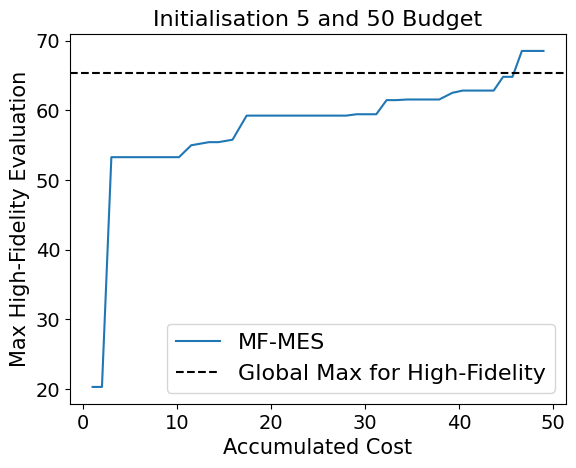

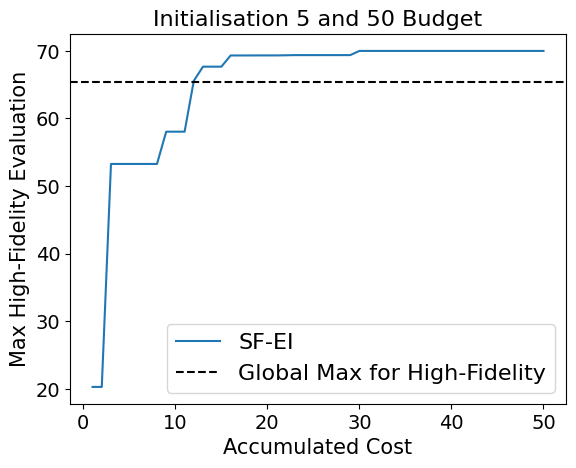

In [217]:

plt.figure()
plot_cost(domain, modelDict,f'Initialisation {N_INIT} and {ALLOCATED_BUDGET} Budget' )
plt.show()



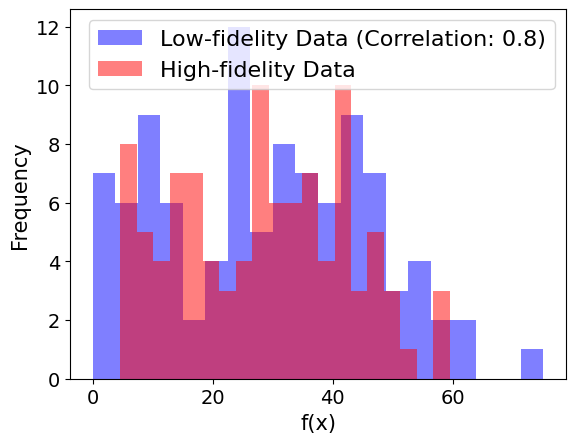

In [81]:

plt.figure()
plot_histogram(domain)
plt.show()

In [63]:
def run_entire_cycle(train_x_full, 
                     train_obj, 
                     fidelity_history, 
                     index_store, 
                     func,
                     sf=False, 
                     no_of_iterations=100000, 
                     allocated_budget=100000
                     ):

    train_x_full = copy.deepcopy(train_x_full)
    train_obj = copy.deepcopy(train_obj)
    fidelity_history = copy.deepcopy(fidelity_history)
    index_store = copy.deepcopy(index_store)

    budget_sum = sum(fidelity_history)
    iteration_counter = 0
    
    while budget_sum <= allocated_budget - 1 and iteration_counter < no_of_iterations:
        model = SingleTaskGP(train_x_full, train_obj) if sf else SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelities=[-1])
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        if not sf:
            acquisition_function, candidate_set = func(model=model, bounds = bounds, fidelity_history = fidelity_history, previous_evaluations=train_obj, train_x_past=train_x_full)
            top_candidate, evaluation, fidelity = optimiseAcquisitionFunction(acquisition_function, index_store, bounds=bounds, candidate_set = candidate_set)
        elif sf:
            print('sfei')
        print('fidelity',fidelity)
        fidelity_history.append(fidelity)

        train_x_full = torch.cat([train_x_full, top_candidate.unsqueeze(0)])
        train_obj = torch.cat([train_obj, torch.tensor([evaluation]).unsqueeze(-1)])

        iteration_counter += 1
        budget_sum += fidelity
        
    cumulative_cost = np.cumsum(fidelity_history).tolist()
    
    return train_x_full, train_obj, cumulative_cost, index_store